In [1]:
import pandas as pd
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import chi2, entropy
from collections import Counter
from sklearn.model_selection import train_test_split

from utils import flatten, build_clicks, rebuild_clicks,rolling_window,compound_unique,read_parse

import vlmc

In [2]:
#integrate into read_parse or utils
def preprocess_book(phonemes,max_depth = 6,shuffle=False):
    alphabet = list(set(flatten(phonemes)))
    mapper = dict(zip(np.sort(alphabet), np.arange(len(alphabet))))
    raw_sequences = [np.array([mapper[b] for b in rs]) for rs in phonemes]
    
    return raw_sequences, mapper

In [3]:
"""
Helper functions for graph making
"""
def includes(b,a):
    """
    if a \subseteq b:
    """
    if b[:len(a)] ==a:
        return True
    return False


def index_in_list(an_element,a_list):
    if an_element in a_list:
        the_index = a_list.index(an_element)
    else:
        a_list.append(an_element)
        the_index = len(a_list)-1
    return the_index, a_list

def decompose(tree,sequence,return_states=False):
    if type(sequence) != list:
        sequence = sequence.tolist()
    blocks =[]
    for i in range(len(sequence)-1):  # for each symbol in sequence
        ind = tree.get_suffix(sequence[:i])
        blocks.append(tree.sequences[ind]+[sequence[i]])

    to_remove = []
    for i in range(len(blocks)-1):
        if includes(blocks[i+1],blocks[i]):
            to_remove.append(i)
            
    
    composition = [blocks[i] for i in range(len(blocks)) if i not in to_remove]
    
    if return_states:
        return composition, blocks
    return composition

In [4]:
"""
Graph plotting routines

"""

def dag_layout(G):
    """
    Graph layout for DAG
    """
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer

    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")
    return pos

def normalize(array,a,b):
    """
    simple helper functions
    """
    if type(array) == list:
        array= np.array(array)
    return (b-a)*(array-array.min())/(array.max()-array.min()+0.0001)+a

def plotLabeledDag(G,labels,ax=None,color= '#E01563',offset=0.1,node_size=40):
    """
    main plotting function
    """
    pos = dag_layout(G)
    if not ax:
        fig, ax = plt.subplots(figsize=(8,5),dpi=200)
    for node in G.nodes:
        ax.text(pos[node][0],pos[node][1]+offset,labels[node],fontsize=11,
                    bbox=dict(boxstyle="round",fc='white'),ha='center')


    opacity = [G.get_edge_data(edge[0],edge[1])['weight'] for edge in G.edges]   
    widths = np.multiply(opacity,normalize(opacity,3,5))
    nx.draw_networkx_nodes(G, pos,node_size=node_size,ax = ax, node_color=color)
    nx.draw_networkx_edges(G, pos,width=widths,ax=ax)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+offset)

In [10]:
"""
Graph handling routines

"""
#merge nodes
def node_merge(G1, n=30):
    """
    Node merging function
    """
    #deterministic prunce
    for _ in range(n):
        to_merge = []
        for edge in G1.edges():
            u,v = edge
            if (G1.out_degree[u] == 1) and (G1.in_degree[v] == 1):
                if [u,v] not in to_merge:
                    to_merge.append([u,v])
                    
        for merger in to_merge:
            #nx.contracted_edge(G,merger, self_loops = False, copy=False)
            G1 = nx.contracted_nodes(G1, *merger, self_loops=False, copy=True)
            
    #remove node if its label is included in all its sucessors (memory increase prune)           
    to_remove = []
    for u in G1.nodes():
        if G1.out_degree(u)>0:
            if np.all([includes(G1.nodes[v]['label'],G1.nodes[u]['label']) for v in G1.successors(u)]):
                to_remove.append(u)
    for node in to_remove:
        G1.remove_node(node)
            
    return G1


def motiff_graph(cache,book,motiff="thin", return_labels=True, merge=True):
    """
    Get graph of states that contain certain motiff (to have entire graph just place empty motiff)
    """
    word_indexes = [i for i in range(len(cache[book]['list_words'])) if motiff in cache[book]['list_words'][i]]
    sequences = [cache[book]['raw_sequences'][i] for i in word_indexes ]
    sequences, counts = compound_unique(sequences)
    blocks = []
    for sequence in sequences:
        blocks.extend(decompose(cache[book]['tree'], sequence,return_states=True)[1])
    blocks, blocks_counts = compound_unique(blocks)
    nodes = [cache[book]['states'].index(block) for block in blocks]
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node, label=cache[book]['states'][node])
    for i,j,p in cache[book]['transitions']:
        if (i in nodes) & (j in nodes):
            G.add_edge(i,j,weight=p)
            
    if merge:
        G = node_merge(G)
    if return_labels:
        labels = {i: translate_label(cache[book]['states'][i],cache[book]['mapper']) for i in nodes}
        if merge:
            labels = get_contraction_labels(G,cache[book]['states'],cache[book]['mapper'])
        return G, labels
    return G

In [6]:
"""
Functions for mergins text lables

"""


def substringSieve(string_list):
    """
    returns maximal strings
    """
    out = []
    for s in string_list:
        if not any([s in r for r in string_list if s != r]):
            out.append(s)
    return out

def translate_label(label, mapper):
    """
    translates list of ints to string accordinf to mapper
    """
    return ''.join([list(mapper.keys())[list(mapper.values()).index(i)] for i in label])


def list_contraction(node, G):
    """
    translates nodes contractions into a list of nodes
    """
    contraction = [node]
    def recursive_keys(nary):
        if 'contraction' in nary:
            for k in nary['contraction'].keys():
                contraction.append(int(k))
                recursive_keys(nary['contraction'][k])
                
    recursive_keys(G.nodes[node])
    return contraction


def get_contraction_labels(G, states, mapper, nodelist=None):
    """
    This is the main function. returns labels of graph with contracted edges
    """
    labels = {}
    if not nodelist:
        nodelist = list(G.nodes())
    for node in nodelist:
        contraction_labels = [translate_label(states[i],mapper) for i in list_contraction(node,G)]
        labels[node]=("|".join(substringSieve(contraction_labels)))
    return labels

In [7]:
path = 'Data/books/'
directory = os.fsencode('Data/books')
titles,cache = [],{}
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".txt"):
        book = pd.read_fwf(path+filename,sep='\n')
        title = book[book.iloc[:,0].str.contains('Title:')].values[0][0][7:]
        titles.append(title)
        
        #check the list "title" to see the other books present here and add them to this list if necessary
        if title in ['Alice’s Adventures in Wonderland','Pride and Prejudice']:
        
            cache[title[:5]] = {}
            #read_book
            list_words = read_parse(path+filename)
            raw_sequences, mapper = preprocess_book(list_words)

            #get tree and cache
            tree = vlmc.VLMC(len(mapper)).fit(raw_sequences)
            
            #cache
            cache[title[:5]]['tree'] = tree
            cache[title[:5]]['raw_sequences'] = raw_sequences
            cache[title[:5]]['list_words'] = list_words
            cache[title[:5]]['mapper'] = mapper
            cache[title[:5]]['states'], cache[title[:5]]['transitions'] = tree.get_states()
            

/home/leitao/Projects/CTI_CETI/Code&Data/vlmc.py:129: RuntimeWarning: invalid value encountered in divide
  return dist / np.sum(dist)
/home/leitao/Projects/CTI_CETI/Code&Data/vlmc.py:129: RuntimeWarning: invalid value encountered in divide
  return dist / np.sum(dist)


Text(0.5, 1.0, 'Merged graph')

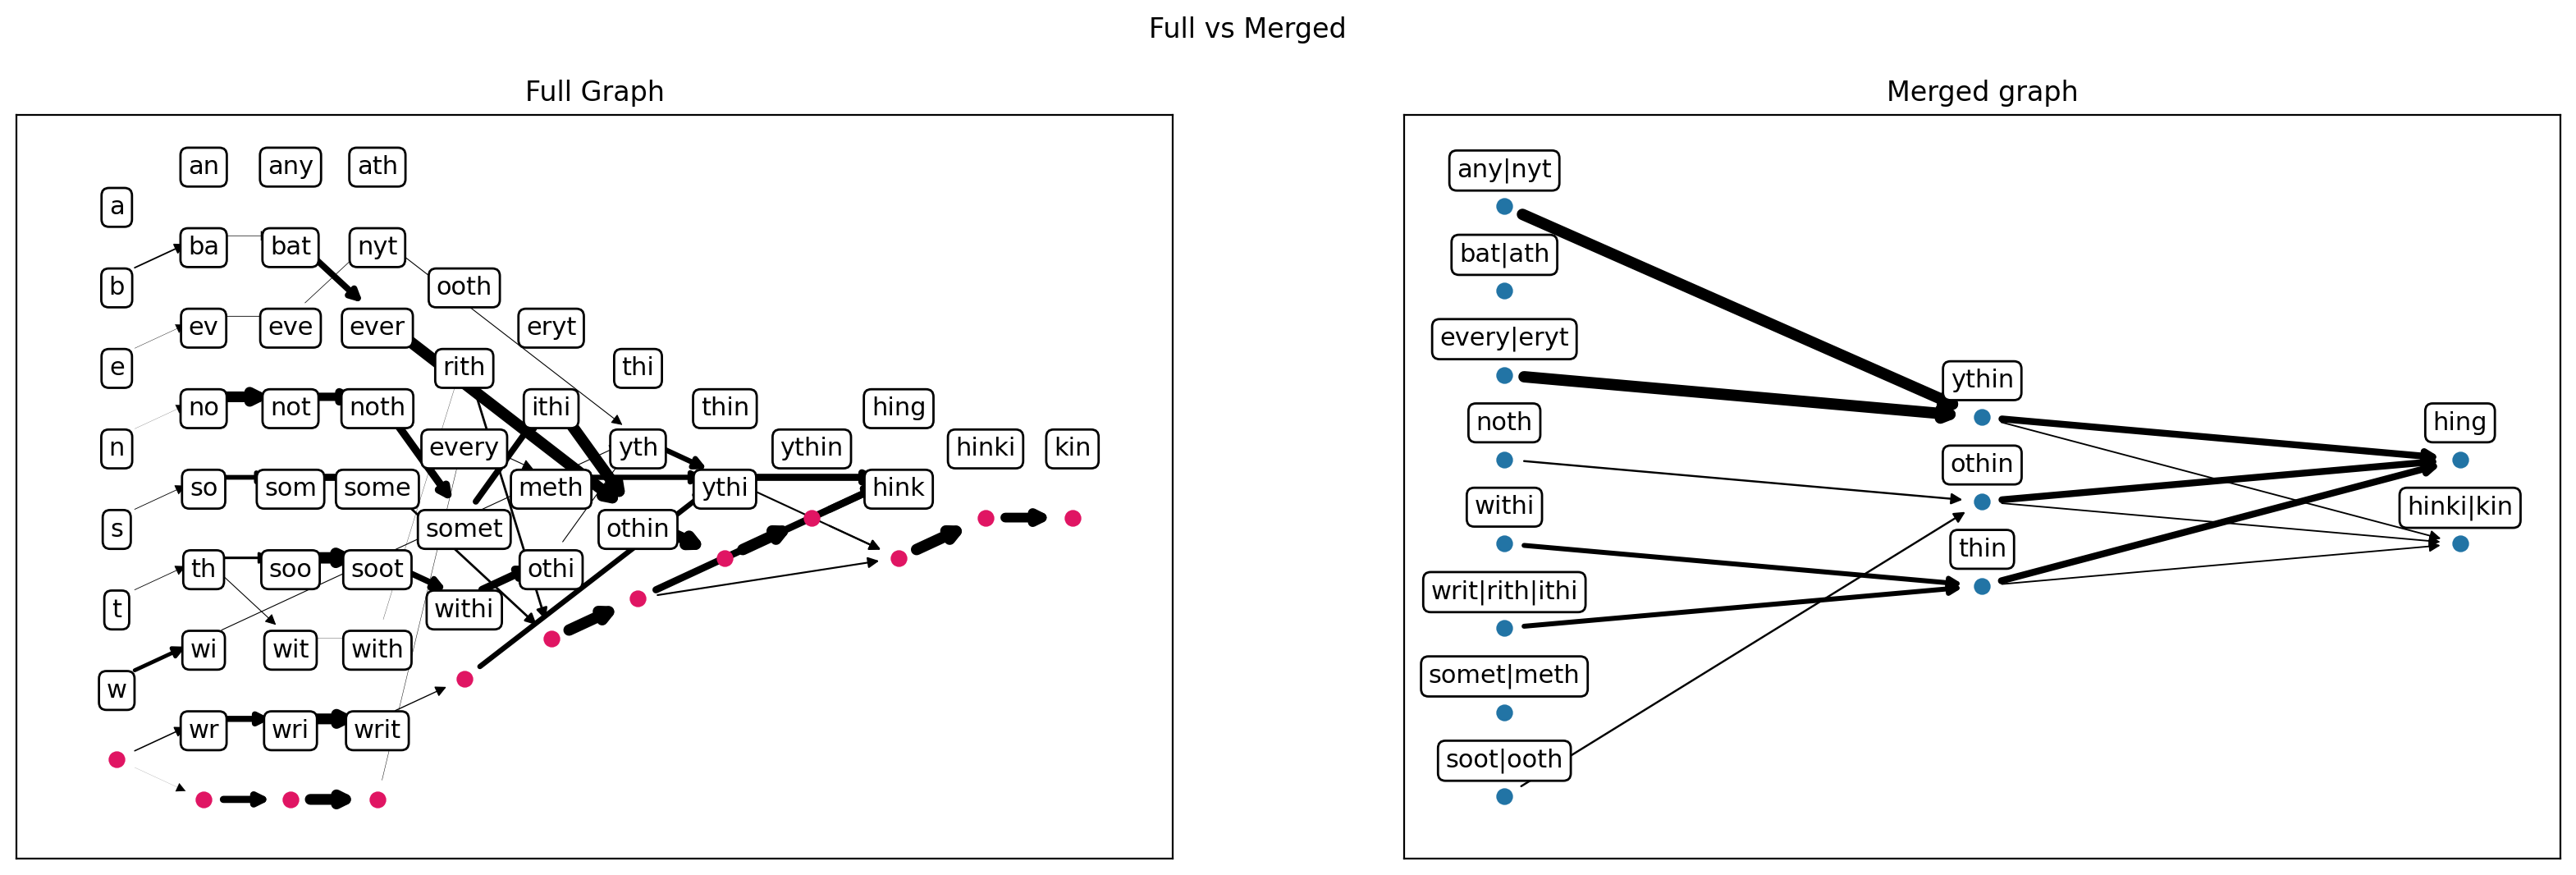

In [35]:
axs = plt.figure(figsize=(20,6),dpi=200).subplot_mosaic("AB")
plt.suptitle('Full vs Merged')
G,labels=motiff_graph(cache, 'Alice',merge=False) #change motiff or book
plotLabeledDag(G,labels,ax=axs['A'])
axs['A'].set_title('Full Graph')

G,labels=motiff_graph(cache, 'Alice',merge=True) #change motiff or book
plotLabeledDag(G,labels,ax=axs['B'],color='#2274A5')
axs['B'].set_title('Merged graph')

Text(0.5, 1.0, 'Pride and Prejudice')

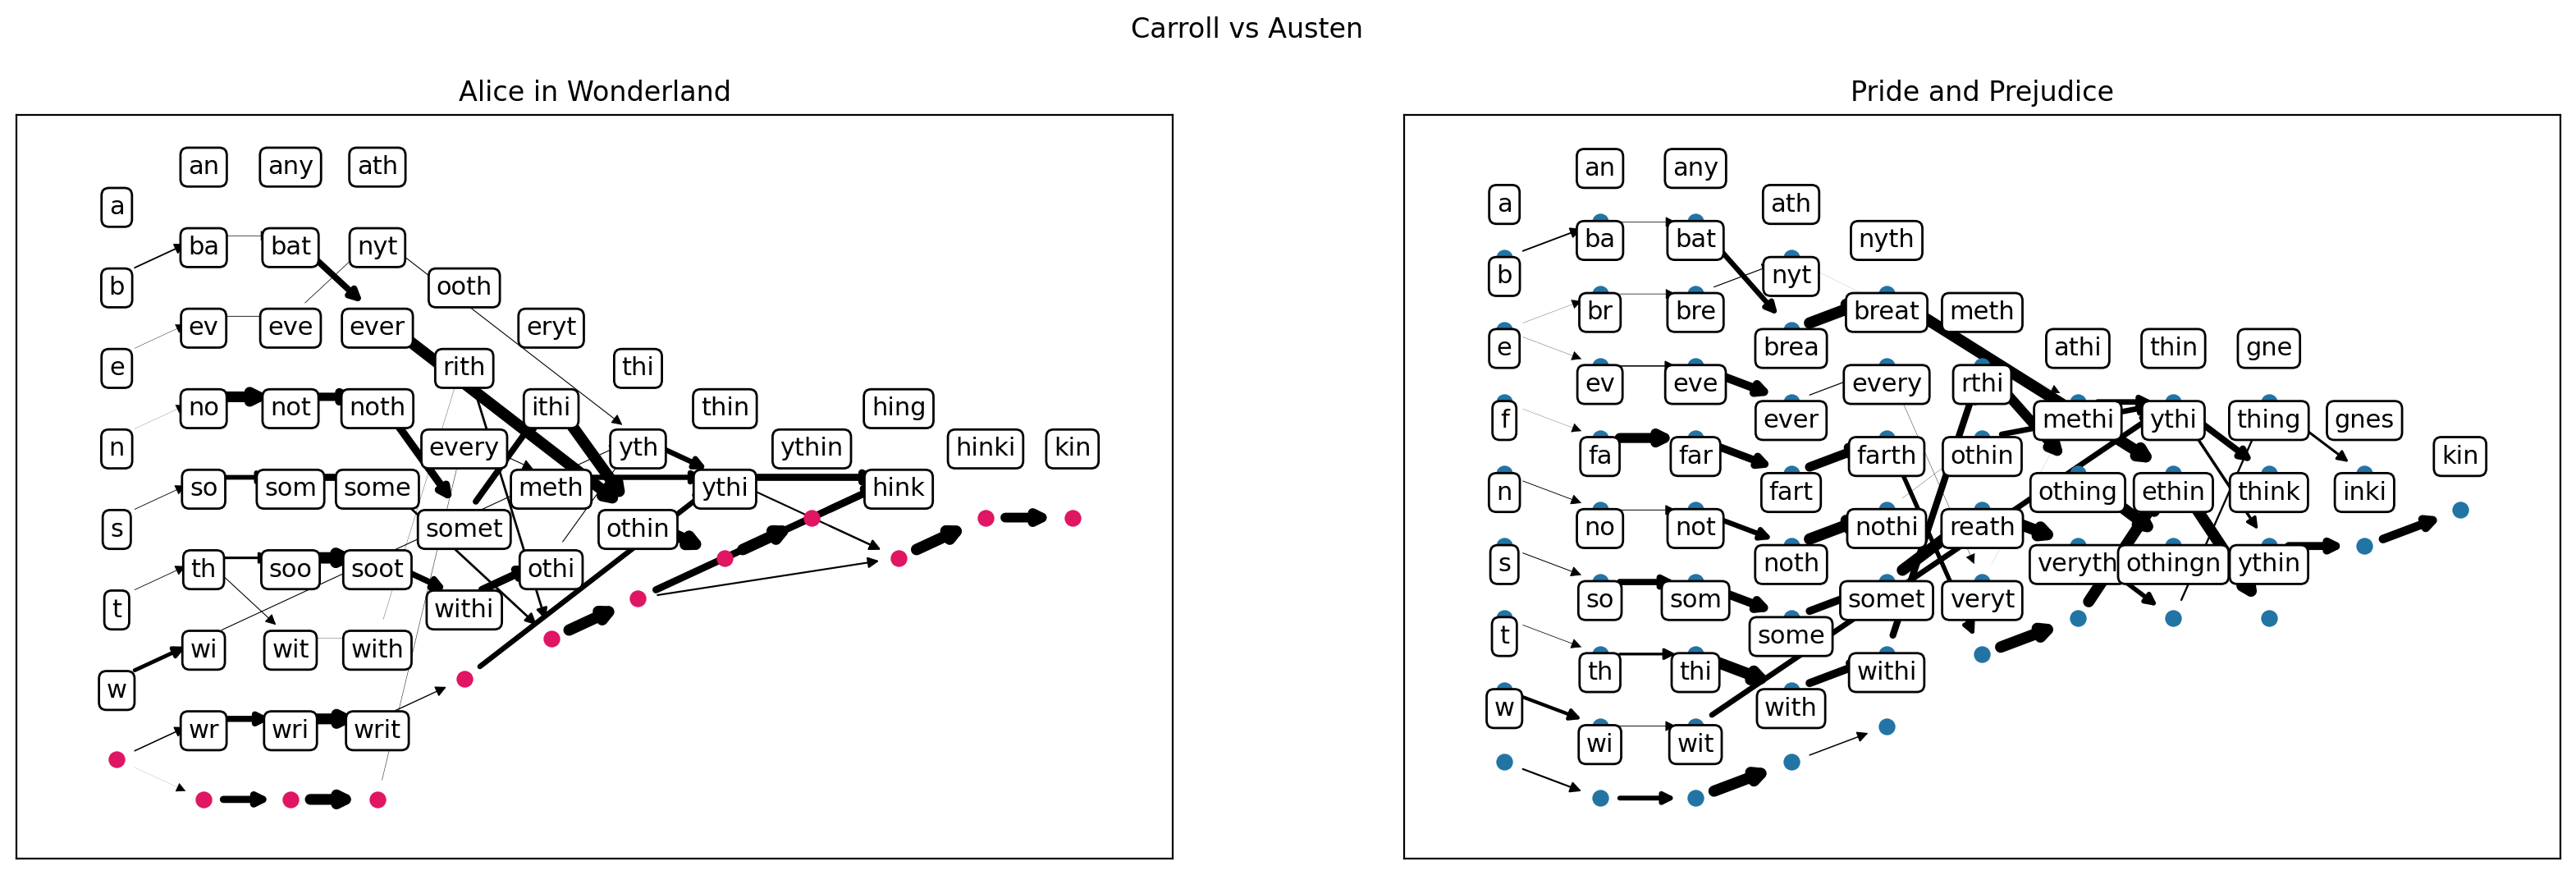

In [34]:

axs = plt.figure(figsize=(20,6),dpi=200).subplot_mosaic("AB")
plt.suptitle('Carroll vs Austen')
G,labels=motiff_graph(cache, 'Alice',merge=False) #change motiff or book
plotLabeledDag(G,labels,ax=axs['A'])
axs['A'].set_title('Alice in Wonderland')

G,labels=motiff_graph(cache, 'Pride',merge=False) #change motiff or book
plotLabeledDag(G,labels,ax=axs['B'],color='#2274A5')
axs['B'].set_title('Pride and Prejudice')

# Whales

In [12]:
def get_whale_data(df,normalized=False, horizon=1,resolution=0.06,K=None):
    """
    function that prepares Dominica data (accepts Pratyusha-style normalization)
    """
    subcache = {}
    ICIs = (df.iloc[:,4:13]).values
    nClicks = df['nClicks'].values
    if normalized:
        ICIs = np.cumsum(ICIs,axis=1)/df['Duration'].values[:,None]
        codas = [coda[:stop-2] for coda, stop in zip(ICIs,nClicks)]
    else:
        codas = [coda[:stop-1] for coda, stop in zip(ICIs,nClicks)]
    
    if normalized:
        book = "normalized"
    else:
        book = "unnormalized"

    discrete_codas,n_bins = vlmc.bin_codas(codas,horizon=horizon, resolution = resolution)
    tree = vlmc.VLMC(n_bins+1).fit(discrete_codas,K=K)
    subcache['raw_sequences'] = discrete_codas
    subcache['tree'] = tree
    subcache['states'], subcache['transitions'] = tree.get_states()
    return subcache

In [13]:
"""
Functions for handling label merging for whale stuff

"""

def get_whale_contraction_label(node, G):
    """
    translates nodes contractions into a list of nodes
    """
    contraction_labels=[]
    def recursive_labels(nary):
        if 'label' in nary:
            contraction_labels.append(nary['label'])
        if 'contraction' in nary:
            for k in nary['contraction'].keys():
                recursive_labels(nary['contraction'][k])
                
    recursive_labels(G.nodes[node])
    return max(contraction_labels, key=len)


def get_whale_contraction_labels(G, nodelist=None):
    """
    This is the main function. returns labels of graph with contracted edges
    """
    labels = {}
    if not nodelist:
        nodelist = list(G.nodes())
    for node in nodelist:
        labels[node] = get_whale_contraction_label(node, G)
    return labels


In [14]:
def whale_motiff_graph(df, cache,book, codas=['5R3'], clans=['EC1'], merge=False,threshold=0.1, return_labels=True):
    coda_condition = (df['CodaType'].isin(codas)).values
    clan_condition = (df['Clan'].isin(clans)).values
    #indexes of selection
    selection = np.nonzero(coda_condition & clan_condition)[0]
    sequences = [cache[book]['raw_sequences'][i] for i in selection]
    sequences, counts = compound_unique(sequences)
    blocks = []
    for sequence in sequences:
        blocks.extend(decompose(cache[book]['tree'], sequence,return_states=True)[1])
    blocks, blocks_counts = compound_unique(blocks)
    nodes = [cache[book]['states'].index(block) for block in blocks]

    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node, label=cache[book]['states'][node])
    for i,j,p in cache[book]['transitions']:
        if (i in nodes) & (j in nodes):
            if p>threshold: #threshold has to be here for whales otherwise its a mess
                G.add_edge(i,j,weight=p)
    if merge:
        G = node_merge(G)
        nodes = G.nodes()
    if return_labels:
        labels = {i:cache[book]['states'][i] for i in nodes}
        if merge:
            labels = get_whale_contraction_labels(G)
        return G, labels
    return G

In [18]:
#use codas = [coda for coda in dominica_data['CodaType'].unique() if "NOISE" not in coda]
#to get all possible coda types (full network)

codas = ['5R3']
clans = ['EC1']

In [19]:
dominica_data = pd.read_csv('Data/shaneCSV.csv')
whalecache = {'normalized':get_whale_data(dominica_data,normalized=True),
        'unnormalized':get_whale_data(dominica_data,normalized=False)}

/tmp/ipykernel_1995530/2151737670.py:9: RuntimeWarning: invalid value encountered in divide
  ICIs = np.cumsum(ICIs,axis=1)/df['Duration'].values[:,None]
/home/leitao/Projects/CTI_CETI/Code&Data/vlmc.py:129: RuntimeWarning: invalid value encountered in divide
  return dist / np.sum(dist)


Text(0.5, 1.0, 'Merged Coda Representation')

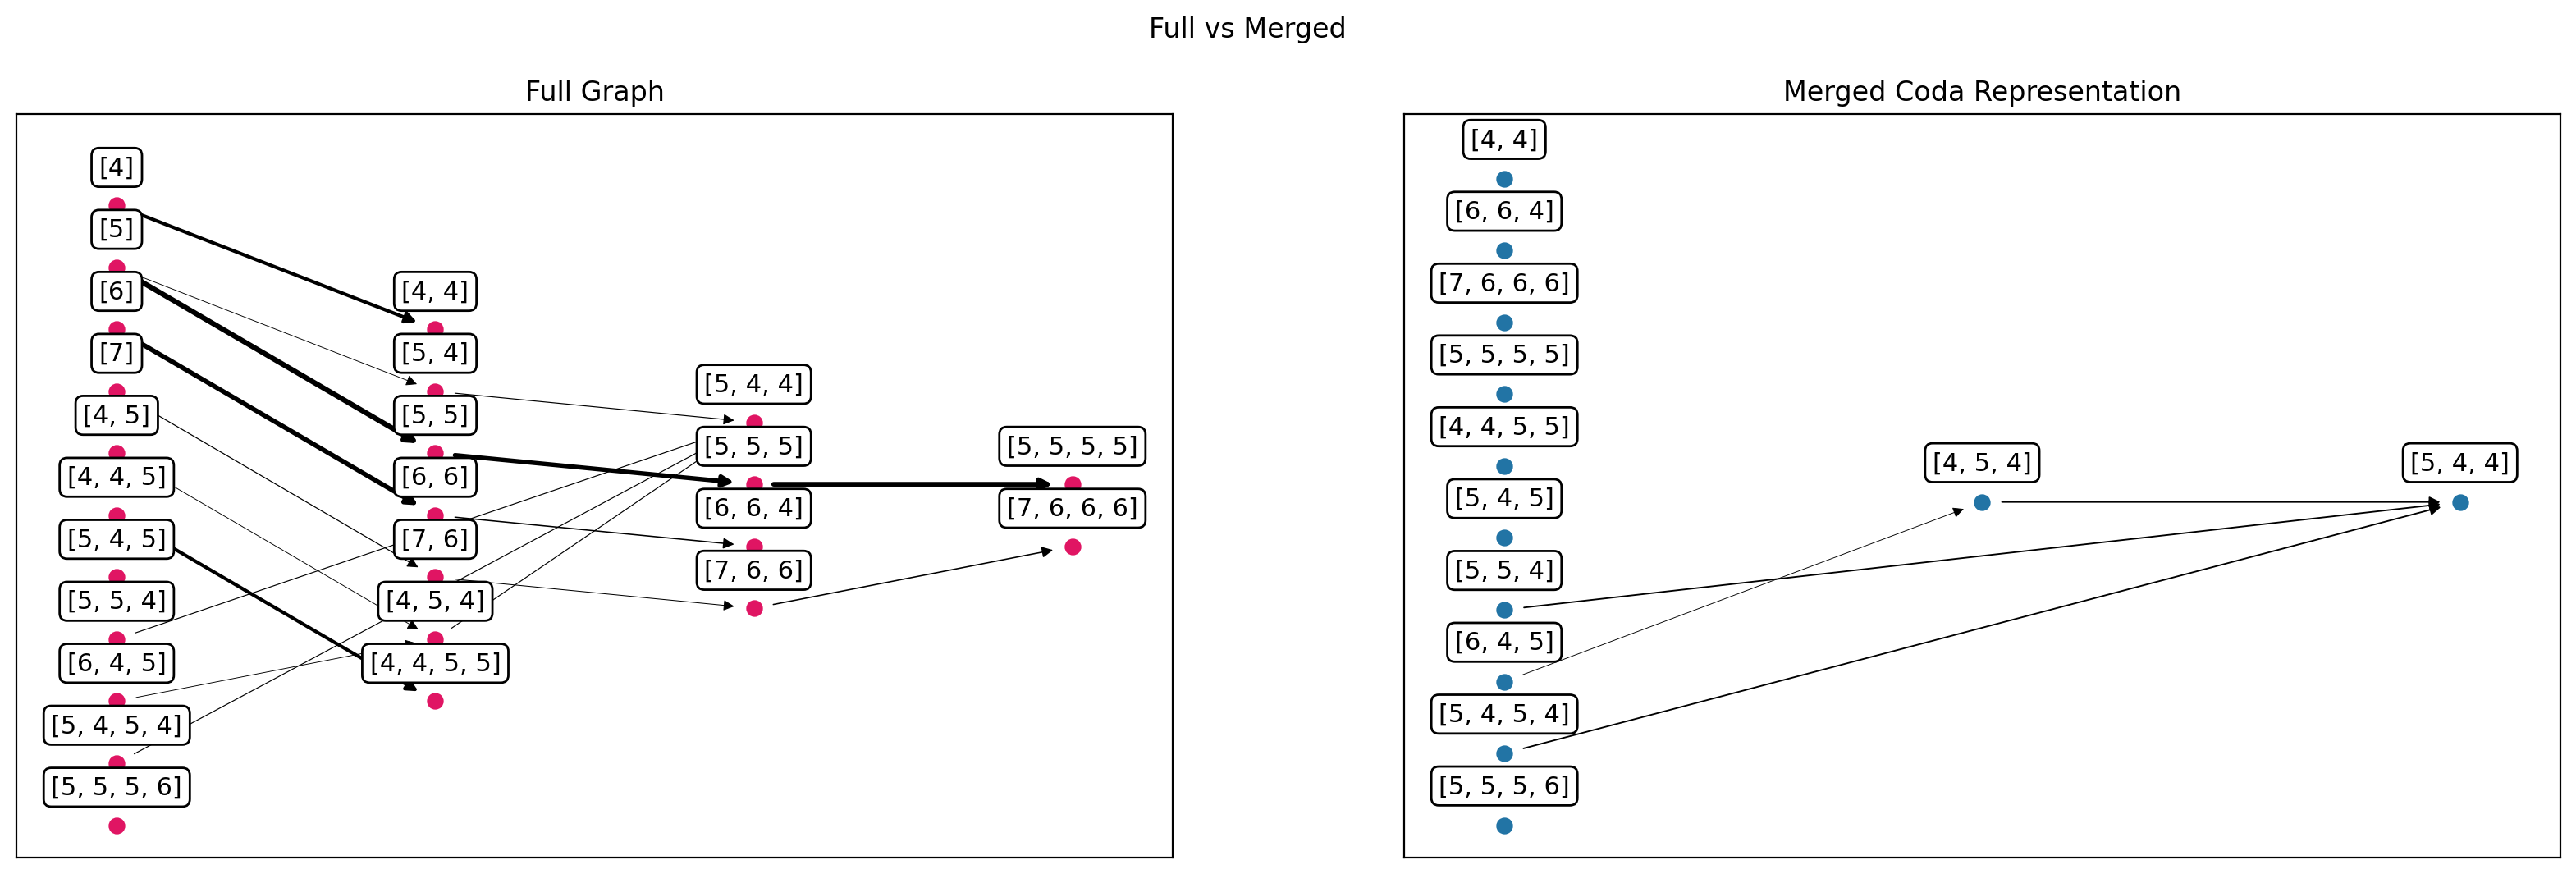

In [20]:

axs = plt.figure(figsize=(20,6),dpi=200).subplot_mosaic("AB")
plt.suptitle('Full vs Merged')
G,labels = whale_motiff_graph(dominica_data, whalecache,'unnormalized',
                       codas=codas,clans=clans,threshold = 0.1,merge=False)
plotLabeledDag(G,labels,ax=axs['A'])
axs['A'].set_title('Full Graph')


G,labels = whale_motiff_graph(dominica_data, whalecache,'unnormalized',
                       codas=codas,clans=clans,threshold = 0.1,merge=True)
plotLabeledDag(G,labels,ax=axs['B'],color='#2274A5')
axs['B'].set_title('Merged Coda Representation')



Text(0.5, 1.0, 'Normalized')

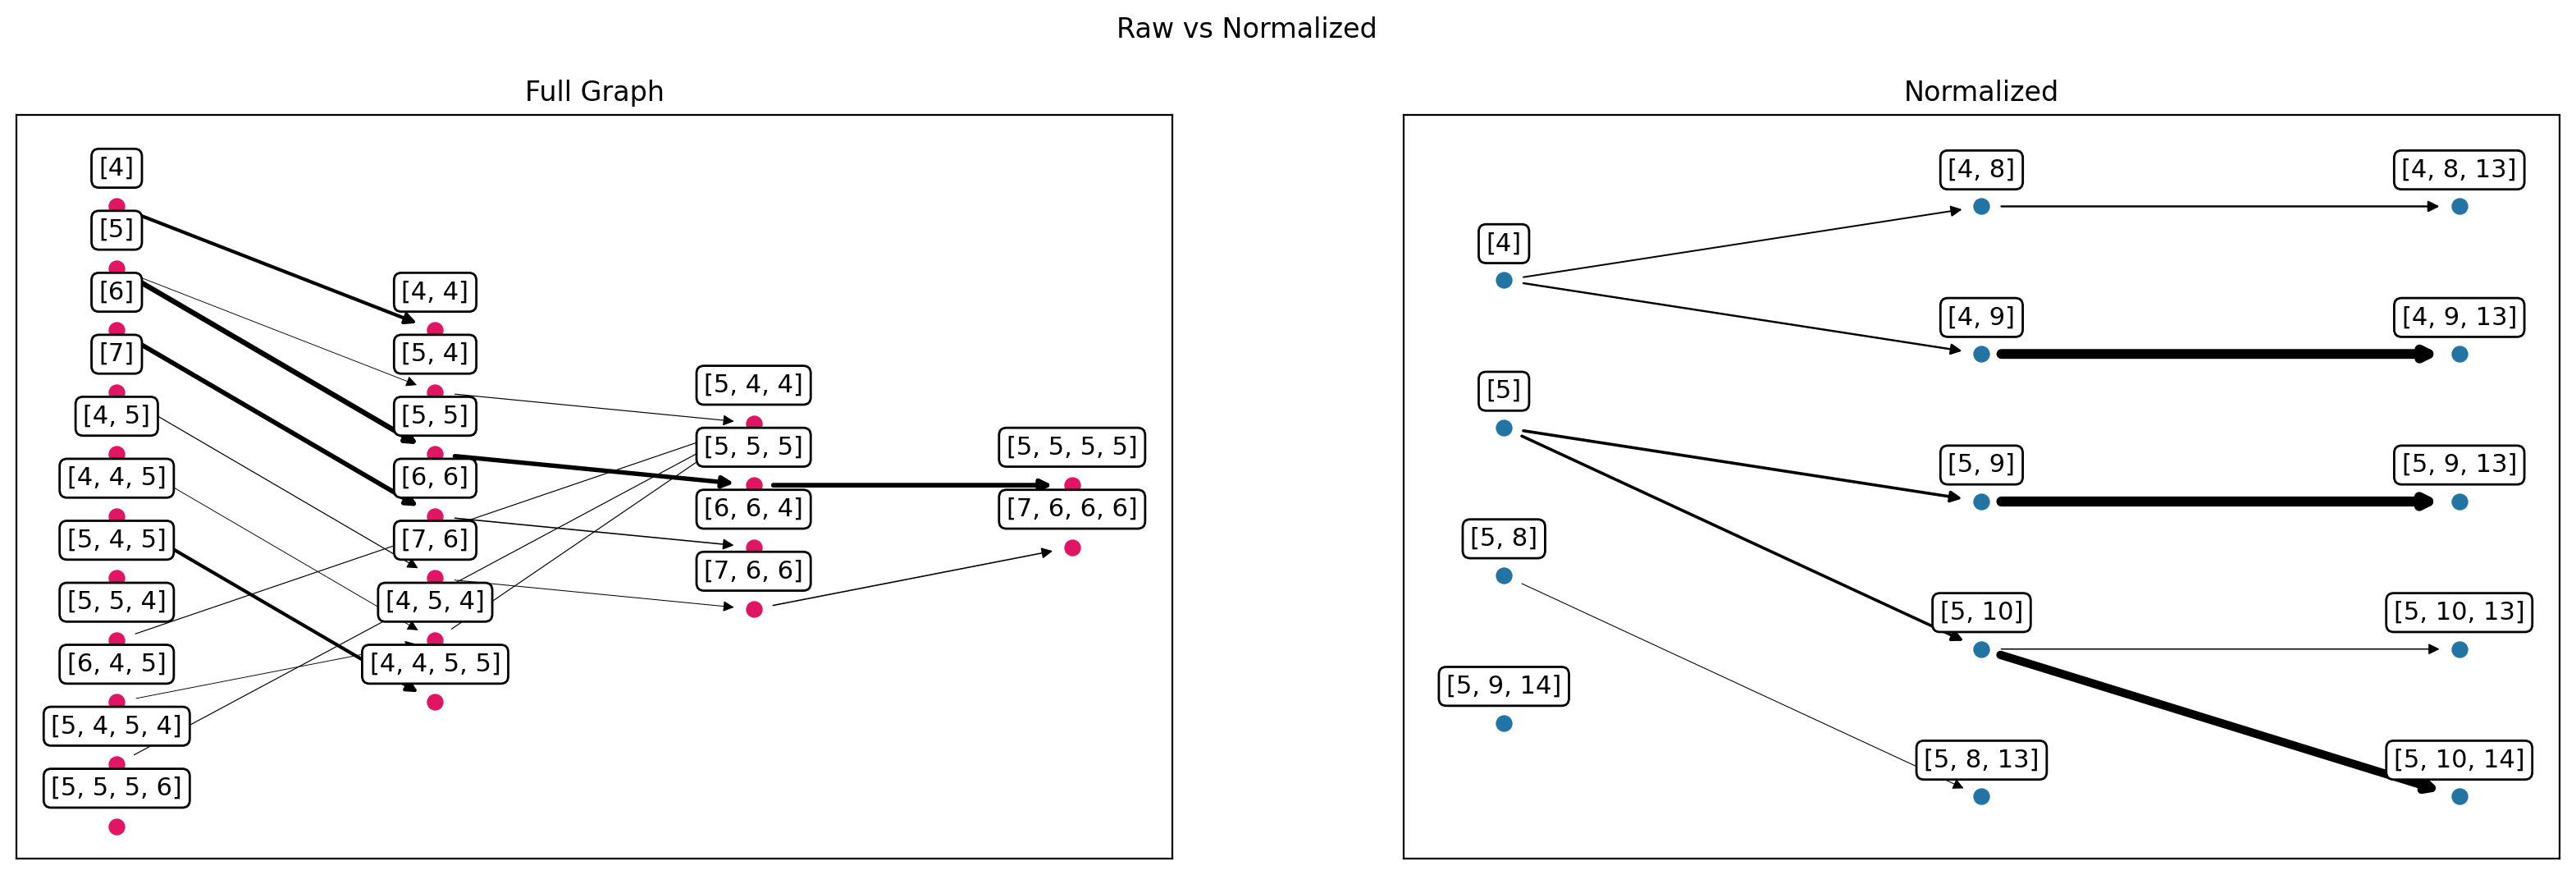

In [21]:
axs = plt.figure(figsize=(20,6),dpi=200).subplot_mosaic("AB")
plt.suptitle('Raw vs Normalized')
G,labels = whale_motiff_graph(dominica_data, whalecache,'unnormalized',
                       codas=codas,clans=clans,threshold = 0.1,merge=False)
plotLabeledDag(G,labels,ax=axs['A'])
axs['A'].set_title('Full Graph')


G,labels = whale_motiff_graph(dominica_data, whalecache,'normalized',
                       codas=codas,clans=clans,threshold = 0.1,merge=False)
plotLabeledDag(G,labels,ax=axs['B'],color='#2274A5')
axs['B'].set_title('Normalized')
